# Introduction

This code is almost identical to 1_Individual_LDA_Math.ipynb, but it has been adjusted for all three subjects (mathematics, statistics, and computer science).

In [18]:
from pymongo import MongoClient
import pymongo

import re

import nltk
from nltk.corpus import stopwords

import pandas as pd
import numpy as np

# gensim
from gensim import corpora, models, similarities, matutils
from gensim.corpora import Dictionary
import gensim

# sklearn
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import PCA

# logging for gensim (set to INFO)
import logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)

import plotly as py
import plotly.graph_objs as go
from plotly import offline
py.offline.init_notebook_mode(connected=True)

import colorlover as cl

import math

import pickle

import matplotlib.pyplot as plt
%matplotlib inline

from wordcloud import WordCloud
from PIL import Image

In [2]:
packages = (('Pymongo', pymongo), ('NLTK', nltk), ('Gensim', gensim),
           ('Regex', re),('Plotly',py))

for package in packages:
    print('{0} version: {1}'.format(package[0],package[1].__version__))
    
!Python -V

Pymongo version: 3.2.2
NLTK version: 3.2.5
Gensim version: 3.3.0
Regex version: 2.2.1
Plotly version: 2.2.3
Python 3.6.4 :: Anaconda custom (64-bit)


# Get Subset of Data From Mongo

In [3]:
client = MongoClient(port=12345) # this is the port set by the SSH tunnel
db = client.research_papers
db.collection_names()

['cs_papers', 'math_papers', 'stat_papers']

## Combining All Articles

In [5]:
databases = [db.cs_papers.find(), db.stat_papers.find(), db.math_papers.find()]
all_papers = []

for database in databases:
    
    current_paper = database

    for pape in current_paper:    
        article = pape['article']
        if article:
            if len(article) > 5000:
                all_papers.append(pape)
                
print('There are a total of {0} articles.'.format(len(all_papers)))

There are a total of 3094 articles.


# Cleaning!!

The word cid it the top word in all classes and seems to stand for random mathematical things, like: fractions, matrices, not equal to, and the box at the end of a proof to signify it is the end of the proof.  Because of this I will take it out of the set.

Also ligatures appear a lot in the translation, the following set was created from the Wikipedea page on ligatures.

In [6]:
ligatures = {'Ꜳ':'AA', 'ꜳ':'aa', 'Æ':'AE', 'æ':'ae', 'Ꜵ':'AO', 'ꜵ':'ao',
            'Ꜷ':'AU', 'ꜷ':'au', 'Ꜹ':'AV', 'ꜹ':'av', 'Ꜻ':'AV', 'ꜻ':'av',
            'Ꜽ':'AY', 'ꜽ':'ay', '🙰':'et', 'ﬀ':'ff', 'ﬃ':'ffi', 'ﬄ':'ffl', 
            'ﬁ':'fi', 'ﬂ':'fl', 'Œ':'OE', 'œ':'oe', 'Ꝏ':'OO', 'ꝏ':'oo', 
            'ﬆ':'st', 'Ꜩ':'TZ', 'ꜩ':'tz', 'ᵫ':'ue', 'Ꝡ':'VY', 'ꝡ':'vy'}

for lig in ligatures:
    re_lig = re.compile(lig)

    for pape in all_papers:
        pape['article'] = re.sub(re_lig, ligatures[lig], pape['article'])

In [7]:
re_cid = re.compile('cid')
et_al_cid = re.compile('et al')

for pape in all_papers:
    pape['article'] = re.sub(re_cid, ' ', pape['article'])
    pape['article'] = re.sub(et_al_cid, '', pape['article'])

## Sanity Check

Do the top words make sense?  

In this section you can see the top words for the individual topics (math, stats and computer science).  Note, the papers classified as math.st and math.pr are statistics and probability papers, so they will be grouped in with the statistics papers.  

In [18]:
topic_of_interest = 'cs'

# to pull all papers in the same area
stat_subj = re.compile(r'stat\.|math\.pr|math\.st')
math_subj = re.compile(r'math\.')
cs_subj = re.compile(r'cs\.')
topic_labels = {'cs':cs_subj, 'stat':stat_subj, 'math':math_subj}

all_text_combined = ''
for pape in all_papers:
    subjects = pape['subject']

    in_topic = False
    topic = topic_labels[topic_of_interest]

    for subj in subjects:
        if re.search(topic, subj):
            in_topic = True

    if in_topic:
        all_text_combined += pape['article']
    
all_text_combined = [all_text_combined]

In [19]:
cv = CountVectorizer(stop_words = 'english')
X = cv.fit_transform(all_text_combined)
word_counts = pd.DataFrame(X.toarray().T, index = cv.get_feature_names(), columns = ['Count'])
word_counts = word_counts.sort_values('Count', ascending = False).head(30)
word_counts.head(5)

,Count
set,24087
data,23990
using,21651
model,21459
algorithm,19631


# Count Vectorizer

The set up for LDA

In [8]:
all_text = []
for pape in all_papers:
    all_text.append(pape['article'])

max_df and min_df are the proportion thresholds

In [9]:
count_vectorizer = CountVectorizer(ngram_range=(1, 3), stop_words = 'english', max_df = 0.95, min_df = 0.05)
counts = count_vectorizer.fit(all_text)
counts = count_vectorizer.transform(all_text).transpose()
word_counts = pd.DataFrame(counts.toarray(), index = count_vectorizer.get_feature_names())
word_counts.head(3)

,0,1,2,3,4,5,6,7,8,9,...,3084,3085,3086,3087,3088,3089,3090,3091,3092,3093
aa,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
ab,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
abelian,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,2,0


In [10]:
corpus = matutils.Sparse2Corpus(counts)
id2word = dict((v, k) for k, v in count_vectorizer.vocabulary_.items())
len(id2word)

4604

# LDA
The good stuff...

In [20]:
num_topics = 3

In [21]:
lda = models.LdaModel(corpus=corpus, num_topics=num_topics, id2word=id2word, passes = 100, minimum_probability = 0)

2018-04-11 19:32:54,829 : INFO : using symmetric alpha at 0.3333333333333333
2018-04-11 19:32:54,831 : INFO : using symmetric eta at 0.3333333333333333
2018-04-11 19:32:54,832 : INFO : using serial LDA version on this node
2018-04-11 19:32:54,896 : INFO : running online (multi-pass) LDA training, 3 topics, 100 passes over the supplied corpus of 3094 documents, updating model once every 2000 documents, evaluating perplexity every 3094 documents, iterating 50x with a convergence threshold of 0.001000
2018-04-11 19:32:55,114 : INFO : PROGRESS: pass 0, at document #2000/3094
2018-04-11 19:33:01,116 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 19:33:01,118 : INFO : topic #0 (0.333): 0.008*"data" + 0.005*"set" + 0.005*"time" + 0.005*"model" + 0.005*"algorithm" + 0.004*"using" + 0.004*"function" + 0.004*"number" + 0.004*"section" + 0.004*"let"
2018-04-11 19:33:01,119 : INFO : topic #1 (0.333): 0.008*"model" + 0.006*"set" + 0.005*"data" + 0.005*"let" +

2018-04-11 19:34:33,993 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 19:34:33,996 : INFO : topic #0 (0.333): 0.009*"data" + 0.009*"model" + 0.006*"using" + 0.005*"time" + 0.005*"set" + 0.005*"number" + 0.005*"algorithm" + 0.004*"used" + 0.004*"figure" + 0.004*"learning"
2018-04-11 19:34:33,997 : INFO : topic #1 (0.333): 0.015*"let" + 0.011*"theorem" + 0.009*"proof" + 0.008*"lemma" + 0.007*"set" + 0.006*"following" + 0.006*"case" + 0.005*"function" + 0.005*"follows" + 0.005*"proposition"
2018-04-11 19:34:33,997 : INFO : topic #2 (0.333): 0.007*"log" + 0.006*"matrix" + 0.005*"theorem" + 0.005*"problem" + 0.005*"pp" + 0.005*"bound" + 0.005*"proof" + 0.005*"let" + 0.005*"given" + 0.005*"algorithm"
2018-04-11 19:34:33,998 : INFO : topic diff=0.083545, rho=0.390822
2018-04-11 19:34:48,685 : INFO : -7.427 per-word bound, 172.1 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 19:34:48,686 : INFO : PROGRESS:

2018-04-11 19:36:07,333 : INFO : topic #2 (0.333): 0.008*"log" + 0.006*"problem" + 0.006*"probability" + 0.006*"matrix" + 0.006*"bound" + 0.006*"random" + 0.005*"algorithm" + 0.005*"given" + 0.005*"theorem" + 0.005*"pp"
2018-04-11 19:36:07,334 : INFO : topic diff=0.053804, rho=0.307918
2018-04-11 19:36:22,058 : INFO : -7.421 per-word bound, 171.4 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 19:36:22,059 : INFO : PROGRESS: pass 8, at document #3094/3094
2018-04-11 19:36:24,801 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 19:36:24,805 : INFO : topic #0 (0.333): 0.010*"data" + 0.010*"model" + 0.006*"using" + 0.006*"time" + 0.005*"number" + 0.005*"figure" + 0.004*"used" + 0.004*"set" + 0.004*"algorithm" + 0.004*"models"
2018-04-11 19:36:24,806 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.008*"lemma" + 0.007*"set" + 0.006*"following" + 0.006*"case" + 0.005*"function" +

2018-04-11 19:37:54,146 : INFO : PROGRESS: pass 12, at document #3094/3094
2018-04-11 19:37:56,839 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 19:37:56,843 : INFO : topic #0 (0.333): 0.010*"data" + 0.010*"model" + 0.006*"using" + 0.006*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.004*"set" + 0.004*"algorithm" + 0.004*"models"
2018-04-11 19:37:56,844 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.008*"lemma" + 0.007*"set" + 0.006*"following" + 0.006*"case" + 0.005*"function" + 0.005*"proposition" + 0.005*"follows"
2018-04-11 19:37:56,844 : INFO : topic #2 (0.333): 0.009*"log" + 0.006*"random" + 0.006*"probability" + 0.006*"problem" + 0.005*"bound" + 0.005*"given" + 0.005*"distribution" + 0.005*"function" + 0.005*"matrix" + 0.005*"information"
2018-04-11 19:37:56,845 : INFO : topic diff=0.040619, rho=0.262188
2018-04-11 19:37:57,084 : INFO : PROGRESS: pass 13, at document #2000/3094
2018-04-11 19:38:0

2018-04-11 19:39:26,542 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.008*"lemma" + 0.007*"set" + 0.006*"following" + 0.006*"case" + 0.005*"function" + 0.005*"proposition" + 0.005*"space"
2018-04-11 19:39:26,543 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.006*"problem" + 0.006*"distribution" + 0.006*"function" + 0.005*"given" + 0.005*"bound" + 0.005*"information" + 0.005*"matrix"
2018-04-11 19:39:26,544 : INFO : topic diff=0.034154, rho=0.232201
2018-04-11 19:39:28,021 : INFO : PROGRESS: pass 17, at document #2000/3094
2018-04-11 19:39:33,253 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 19:39:33,257 : INFO : topic #0 (0.333): 0.010*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set" + 0.004*"models"
2018-04-11 19:39:33,257 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof"

2018-04-11 19:40:57,452 : INFO : topic diff=0.030390, rho=0.210599
2018-04-11 19:40:57,692 : INFO : PROGRESS: pass 21, at document #2000/3094
2018-04-11 19:41:02,966 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 19:41:02,969 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set" + 0.004*"algorithm"
2018-04-11 19:41:02,970 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.007*"set" + 0.006*"following" + 0.006*"case" + 0.005*"function" + 0.005*"proposition" + 0.005*"space"
2018-04-11 19:41:02,972 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.006*"distribution" + 0.006*"problem" + 0.006*"function" + 0.006*"given" + 0.005*"bound" + 0.005*"matrix" + 0.005*"algorithm"
2018-04-11 19:41:02,972 : INFO : topic diff=0.030919, rho=0.206078
2018-04-11 19:41:17,166 : IN

2018-04-11 19:42:32,237 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"function" + 0.005*"proposition" + 0.005*"space"
2018-04-11 19:42:32,238 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.006*"distribution" + 0.006*"function" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"matrix" + 0.005*"algorithm"
2018-04-11 19:42:32,239 : INFO : topic diff=0.028090, rho=0.190530
2018-04-11 19:42:46,500 : INFO : -7.419 per-word bound, 171.2 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 19:42:46,501 : INFO : PROGRESS: pass 25, at document #3094/3094
2018-04-11 19:42:49,169 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 19:42:49,172 : INFO : topic #0 (0.333): 0.010*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 

2018-04-11 19:44:02,797 : INFO : topic diff=0.025949, rho=0.178041
2018-04-11 19:44:17,019 : INFO : -7.419 per-word bound, 171.2 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 19:44:17,020 : INFO : PROGRESS: pass 29, at document #3094/3094
2018-04-11 19:44:19,696 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 19:44:19,698 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"algorithm" + 0.005*"set"
2018-04-11 19:44:19,699 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.008*"lemma" + 0.007*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"function" + 0.005*"space"
2018-04-11 19:44:19,700 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.006*"distribution" + 0.006*"function" + 0.006*"problem" + 0.006*"given" + 

2018-04-11 19:45:48,804 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"algorithm" + 0.005*"learning" + 0.005*"set"
2018-04-11 19:45:48,805 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.008*"lemma" + 0.007*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"function" + 0.005*"space"
2018-04-11 19:45:48,806 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.006*"distribution" + 0.006*"function" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"information" + 0.005*"matrix"
2018-04-11 19:45:48,807 : INFO : topic diff=0.023643, rho=0.167725
2018-04-11 19:45:49,043 : INFO : PROGRESS: pass 34, at document #2000/3094
2018-04-11 19:45:54,277 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 19:45:54,280 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"usin

2018-04-11 19:47:18,132 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.006*"distribution" + 0.006*"function" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"matrix" + 0.005*"theorem"
2018-04-11 19:47:18,132 : INFO : topic diff=0.022337, rho=0.159017
2018-04-11 19:47:18,366 : INFO : PROGRESS: pass 38, at document #2000/3094
2018-04-11 19:47:23,555 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 19:47:23,558 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"algorithm" + 0.005*"set"
2018-04-11 19:47:23,559 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"space" + 0.005*"function"
2018-04-11 19:47:23,560 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probabil

2018-04-11 19:48:53,971 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"algorithm" + 0.005*"set"
2018-04-11 19:48:53,972 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"space" + 0.005*"function"
2018-04-11 19:48:53,973 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"distribution" + 0.006*"function" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"matrix" + 0.005*"theorem"
2018-04-11 19:48:53,974 : INFO : topic diff=0.021430, rho=0.149827
2018-04-11 19:49:08,258 : INFO : -7.418 per-word bound, 171.1 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 19:49:08,259 : INFO : PROGRESS: pass 42, at document #3094/3094
2018-04-11 19:49:10,913 : INFO : merging changes fr

2018-04-11 19:50:23,222 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"distribution" + 0.007*"function" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"theorem" + 0.005*"matrix"
2018-04-11 19:50:23,223 : INFO : topic diff=0.020473, rho=0.143522
2018-04-11 19:50:37,379 : INFO : -7.418 per-word bound, 171.1 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 19:50:37,380 : INFO : PROGRESS: pass 46, at document #3094/3094
2018-04-11 19:50:40,040 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 19:50:40,043 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"algorithm" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 19:50:40,044 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.007*"set" + 0.006*"following" + 0.006*"case" + 0.005*

2018-04-11 19:52:06,573 : INFO : PROGRESS: pass 50, at document #3094/3094
2018-04-11 19:52:09,223 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 19:52:09,226 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"figure" + 0.005*"algorithm" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 19:52:09,227 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"space" + 0.005*"function"
2018-04-11 19:52:09,228 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"theorem" + 0.005*"matrix"
2018-04-11 19:52:09,229 : INFO : topic diff=0.019301, rho=0.137951
2018-04-11 19:52:09,463 : INFO : PROGRESS: pass 51, at document #2000/3094
2018-04-11 19:52:14,63

2018-04-11 19:53:39,498 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"theorem" + 0.005*"matrix"
2018-04-11 19:53:39,499 : INFO : topic diff=0.018599, rho=0.132983
2018-04-11 19:53:39,740 : INFO : PROGRESS: pass 55, at document #2000/3094
2018-04-11 19:53:44,920 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 19:53:44,923 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"algorithm" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 19:53:44,924 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"space" + 0.005*"follows"
2018-04-11 19:53:44,925 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probabili

2018-04-11 19:55:14,005 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"algorithm" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 19:55:14,006 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"space" + 0.005*"follows"
2018-04-11 19:55:14,007 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"distribution" + 0.007*"function" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"theorem" + 0.005*"matrix"
2018-04-11 19:55:14,007 : INFO : topic diff=0.018094, rho=0.127467
2018-04-11 19:55:28,177 : INFO : -7.418 per-word bound, 171.0 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 19:55:28,178 : INFO : PROGRESS: pass 59, at document #3094/3094
2018-04-11 19:55:30,827 : INFO : merging changes fro

2018-04-11 19:56:43,094 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"theorem" + 0.005*"matrix"
2018-04-11 19:56:43,095 : INFO : topic diff=0.017527, rho=0.123516
2018-04-11 19:56:57,208 : INFO : -7.418 per-word bound, 171.0 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 19:56:57,209 : INFO : PROGRESS: pass 63, at document #3094/3094
2018-04-11 19:56:59,855 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 19:56:59,858 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"algorithm" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 19:56:59,859 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*

2018-04-11 19:58:27,629 : INFO : PROGRESS: pass 67, at document #3094/3094
2018-04-11 19:58:30,266 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 19:58:30,269 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"algorithm" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 19:58:30,270 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"space" + 0.005*"follows"
2018-04-11 19:58:30,271 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"bound" + 0.005*"theorem" + 0.005*"matrix"
2018-04-11 19:58:30,271 : INFO : topic diff=0.016800, rho=0.119911
2018-04-11 19:58:30,511 : INFO : PROGRESS: pass 68, at document #2000/3094
2018-04-11 19:58:35,668

2018-04-11 19:59:59,150 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix"
2018-04-11 19:59:59,151 : INFO : topic diff=0.016349, rho=0.116605
2018-04-11 19:59:59,386 : INFO : PROGRESS: pass 72, at document #2000/3094
2018-04-11 20:00:04,589 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 20:00:04,592 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"algorithm" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 20:00:04,593 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"space" + 0.005*"follows"
2018-04-11 20:00:04,594 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probabili

2018-04-11 20:01:33,595 : INFO : topic #0 (0.333): 0.011*"data" + 0.010*"model" + 0.006*"using" + 0.005*"time" + 0.005*"number" + 0.005*"algorithm" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 20:01:33,596 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"space" + 0.005*"proposition" + 0.005*"follows"
2018-04-11 20:01:33,597 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"probability" + 0.007*"random" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix"
2018-04-11 20:01:33,597 : INFO : topic diff=0.016039, rho=0.112833
2018-04-11 20:01:48,947 : INFO : -7.418 per-word bound, 171.0 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 20:01:48,948 : INFO : PROGRESS: pass 76, at document #3094/3094
2018-04-11 20:01:51,580 : INFO : merging changes fro

2018-04-11 20:03:03,867 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"probability" + 0.007*"random" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix"
2018-04-11 20:03:03,867 : INFO : topic diff=0.015654, rho=0.110065
2018-04-11 20:03:18,018 : INFO : -7.418 per-word bound, 171.0 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 20:03:18,019 : INFO : PROGRESS: pass 80, at document #3094/3094
2018-04-11 20:03:20,661 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 20:03:20,663 : INFO : topic #0 (0.333): 0.011*"data" + 0.009*"model" + 0.006*"using" + 0.005*"time" + 0.005*"algorithm" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 20:03:20,664 : INFO : topic #1 (0.333): 0.016*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*

2018-04-11 20:04:47,706 : INFO : PROGRESS: pass 84, at document #3094/3094
2018-04-11 20:04:50,356 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 20:04:50,359 : INFO : topic #0 (0.333): 0.011*"data" + 0.009*"model" + 0.006*"using" + 0.005*"time" + 0.005*"algorithm" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 20:04:50,360 : INFO : topic #1 (0.333): 0.017*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"proposition" + 0.005*"space" + 0.005*"follows"
2018-04-11 20:04:50,361 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix"
2018-04-11 20:04:50,361 : INFO : topic diff=0.015113, rho=0.107491
2018-04-11 20:04:50,605 : INFO : PROGRESS: pass 85, at document #2000/3094
2018-04-11 20:04:55,787

2018-04-11 20:06:20,759 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix"
2018-04-11 20:06:20,760 : INFO : topic diff=0.014797, rho=0.105090
2018-04-11 20:06:20,998 : INFO : PROGRESS: pass 89, at document #2000/3094
2018-04-11 20:06:26,154 : INFO : merging changes from 2000 documents into a model of 3094 documents
2018-04-11 20:06:26,157 : INFO : topic #0 (0.333): 0.011*"data" + 0.009*"model" + 0.006*"using" + 0.005*"time" + 0.005*"algorithm" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 20:06:26,158 : INFO : topic #1 (0.333): 0.017*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"space" + 0.005*"proposition" + 0.005*"follows"
2018-04-11 20:06:26,159 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"probability" + 0.007*"rand

2018-04-11 20:07:57,477 : INFO : topic #0 (0.333): 0.011*"data" + 0.009*"model" + 0.006*"using" + 0.005*"time" + 0.005*"algorithm" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"learning" + 0.005*"set"
2018-04-11 20:07:57,478 : INFO : topic #1 (0.333): 0.017*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"space" + 0.005*"proposition" + 0.005*"follows"
2018-04-11 20:07:57,479 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"probability" + 0.007*"random" + 0.007*"function" + 0.007*"distribution" + 0.006*"given" + 0.006*"problem" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix"
2018-04-11 20:07:57,480 : INFO : topic diff=0.014579, rho=0.102304
2018-04-11 20:08:11,900 : INFO : -7.418 per-word bound, 171.0 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 20:08:11,901 : INFO : PROGRESS: pass 93, at document #3094/3094
2018-04-11 20:08:14,640 : INFO : merging changes fro

2018-04-11 20:09:28,795 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"probability" + 0.007*"random" + 0.007*"function" + 0.007*"distribution" + 0.006*"given" + 0.006*"problem" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix"
2018-04-11 20:09:28,795 : INFO : topic diff=0.014292, rho=0.100227
2018-04-11 20:09:43,272 : INFO : -7.418 per-word bound, 171.0 perplexity estimate based on a held-out corpus of 1094 documents with 2898657 words
2018-04-11 20:09:43,272 : INFO : PROGRESS: pass 97, at document #3094/3094
2018-04-11 20:09:46,002 : INFO : merging changes from 1094 documents into a model of 3094 documents
2018-04-11 20:09:46,005 : INFO : topic #0 (0.333): 0.011*"data" + 0.009*"model" + 0.006*"using" + 0.005*"time" + 0.005*"algorithm" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"set" + 0.005*"learning"
2018-04-11 20:09:46,006 : INFO : topic #1 (0.333): 0.017*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*

In [22]:
lda.print_topics(num_words=15)

2018-04-11 20:12:06,545 : INFO : topic #0 (0.333): 0.011*"data" + 0.009*"model" + 0.006*"using" + 0.005*"time" + 0.005*"algorithm" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"set" + 0.005*"learning" + 0.005*"network" + 0.004*"different" + 0.004*"models" + 0.004*"results" + 0.004*"method"
2018-04-11 20:12:06,547 : INFO : topic #1 (0.333): 0.017*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"space" + 0.005*"proposition" + 0.005*"follows" + 0.005*"function" + 0.004*"given" + 0.004*"definition" + 0.004*"section" + 0.004*"defined"
2018-04-11 20:12:06,548 : INFO : topic #2 (0.333): 0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix" + 0.005*"proof" + 0.005*"xi" + 0.004*"information" + 0.004*"time" + 0.004*"case"


[(0,
  '0.011*"data" + 0.009*"model" + 0.006*"using" + 0.005*"time" + 0.005*"algorithm" + 0.005*"number" + 0.005*"figure" + 0.005*"used" + 0.005*"set" + 0.005*"learning" + 0.005*"network" + 0.004*"different" + 0.004*"models" + 0.004*"results" + 0.004*"method"'),
 (1,
  '0.017*"let" + 0.011*"theorem" + 0.009*"proof" + 0.009*"lemma" + 0.008*"set" + 0.006*"following" + 0.006*"case" + 0.005*"space" + 0.005*"proposition" + 0.005*"follows" + 0.005*"function" + 0.004*"given" + 0.004*"definition" + 0.004*"section" + 0.004*"defined"'),
 (2,
  '0.009*"log" + 0.007*"random" + 0.007*"probability" + 0.007*"function" + 0.007*"distribution" + 0.006*"problem" + 0.006*"given" + 0.005*"theorem" + 0.005*"bound" + 0.005*"matrix" + 0.005*"proof" + 0.005*"xi" + 0.004*"information" + 0.004*"time" + 0.004*"case"')]

## Pickle!!!!

In [23]:
with open('All_Subjects_LDA.pkl','wb') as pickle_out:
    pickle.dump(lda, pickle_out)

# with open('All_Subjects_LDA.pkl','rb') as pickle_in:
#     lda = pickle.load(pickle_in)

# PCA

Not needed for dimension reduction, it makes for a good quick plot though.

In [36]:
lda_corpus = lda[corpus]
lda_docs = [doc for doc in lda_corpus]
lda_docs[0:5]

[[(0, 0.97831804), (1, 0.008004166), (2, 0.013677807)],
 [(0, 0.8700701), (1, 0.00027415066), (2, 0.12965578)],
 [(0, 0.8924389), (1, 0.039032094), (2, 0.06852901)],
 [(0, 0.9886877), (1, 0.010888317), (2, 0.00042401298)],
 [(0, 0.86290246), (1, 0.07109778), (2, 0.06599978)]]

In [37]:
lda_X = np.array([])

count = 0
for doc in lda_corpus:
    for prob in doc:
        lda_X = np.append(lda_X,prob[1])

lda_X = lda_X.reshape(-1,3)
lda_X.shape

(3094, 3)

In [38]:
pca = PCA(n_components=3) # Uses SVD
pca.fit(lda_X)
pca_lda_X = pca.transform(lda_X)

In [39]:
pca.explained_variance_ratio_

array([7.11675390e-01, 2.88324610e-01, 8.74416524e-16])

In [40]:
pca.components_

array([[-0.68832961,  0.72449592, -0.03616631],
       [-0.43916854, -0.37652666,  0.8156952 ],
       [ 0.57735027,  0.57735027,  0.57735027]])

# Topics Word Cloud

Thank you [Tiffany Moeller](https://github.com/TifMoe)

Topic 1: rgb(143, 83, 159)

Topic 2: rgb(248, 186, 0)

Topic 3: rgb(231, 119, 21)

In [33]:
def random_color_func(word, font_size, position, orientation, random_state=None,
                    **kwargs):
    r,g,b = 231, 119, 21
    
    prop = (1-0.5)*np.random.random()+0.5
    r = str(int(prop*r))
    g = str(int(prop*g))
    b = str(int(prop*b))
    return "rgb(" + r + "," + g + ", " + b + ")" 

In [34]:
def generate_cloud(lda):

    cloud_mask = np.array(Image.open('word_cloud_mask.jpg'))
    
    colors = cl.scales['3']['qual']['Set1']

    for t_index in range(lda.num_topics):
        wordcloud = WordCloud(background_color="white",
                              max_words=100,
                              height=900,
                              width=1200,
                              relative_scaling=0,
                              color_func = random_color_func,
                              mask=cloud_mask
                             )
        
        wordcloud.fit_words(lda.show_topic(t_index, 50))
        
        plt.figure(figsize=(15,12))
        plt.imshow(wordcloud, interpolation='bilinear')
        plt.axis("off")
        plt.show()

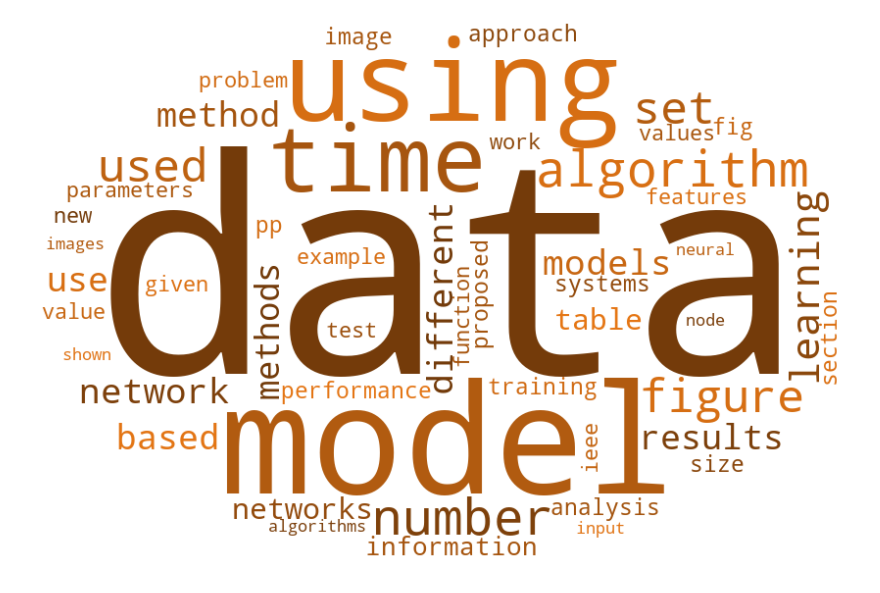

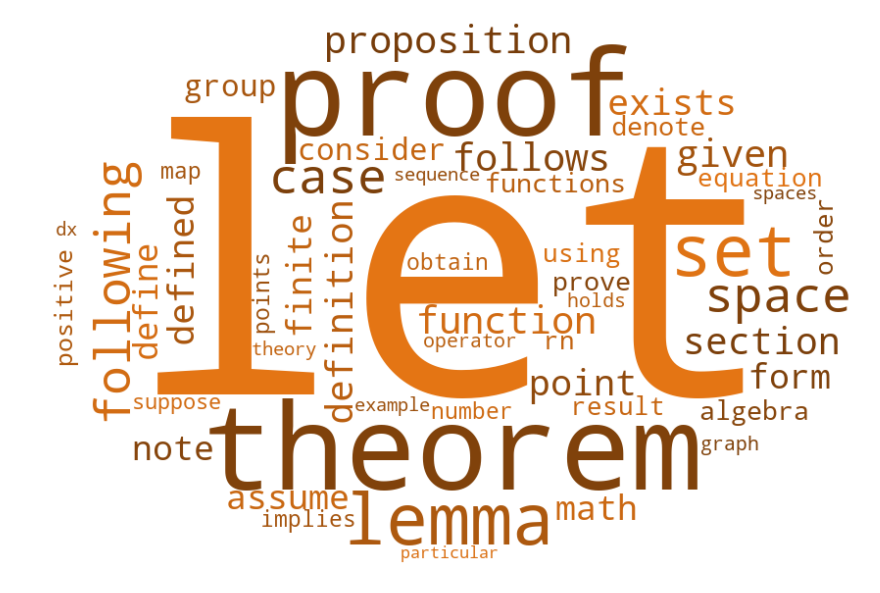

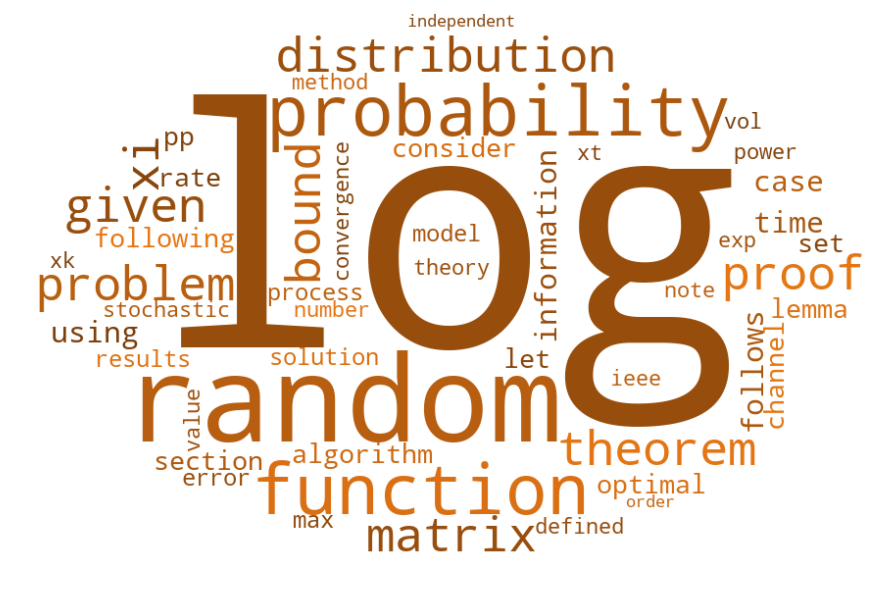

In [35]:
generate_cloud(lda)

# Logical Grouping of Subjects

To create the plots, I will group each of the subjects for a given paper.  If there is more that one subject, I will add the stats of the paper to each subject grouping.

For each paper the subject will be added to the first column of the array containing the translated PCA coordinates (pca_lda_X).  Therefore each document will have a row in the PCA coordinates array that looks as follows: subject, coordinate 1, coordinate 2, ...

## All Paper's Main Subject

In [41]:
def get_all_papers_classification(all_papers, pca_lda_X):
    '''
        Gets the main classificaiton (math, stats, cs) 
        for each of the papers.
    '''
    subjects = np.array([])

    for pape in all_papers:

        subj = pape['subject']
        if subj:
            subj = subj[0]
        else:
            subj = 'NA'

        # almost all subjects are given as math.XX
        if subj == 'math-ph':
            subj = 'math'
        else:
            subj = subj.split('.')
            subj = subj[0]

        subjects = np.append(subjects, subj)
    
    subjects = subjects.reshape(-1,1)
    
    pca_lda_X = np.append(subjects, pca_lda_X, axis = 1)
    
    return pca_lda_X

In [42]:
pca_lda_X = get_all_papers_classification(all_papers, pca_lda_X)

In [43]:
groups = ['math','cs','stat']

# Plots of Topics

In [44]:
def pca_plot(title):
    '''
        Outputs the plot of the first two inertias found using the PCA method.
        Each paper is colored by the groupings, which I labeled.
    '''

    colors = cl.scales[str(len(groups))]['qual']['Set1']

    data = []
    for index, group in enumerate(groups):

        locs = (pca_lda_X[:,0] == group)

        points = go.Scatter(
            x = pca_lda_X[locs,1],
            y = pca_lda_X[locs,2],
            mode = 'markers',
            name = group,
            marker = dict(
                opacity = 0.2,
                color = colors[index],
                size = 15
            )
        )

        data.append(points)

    layout = go.Layout(
        autosize=False,
        width=800,
        height=800,
        title=title,
        titlefont=dict(
            size=25
        ),
        xaxis=dict(
            showgrid=False,
            zeroline=True,
            showticklabels=False
        ),
        yaxis=dict(
            showgrid=False,
            zeroline=True,
            showticklabels=False
        )
    )

    # data = [points]
    fig = go.Figure(data=data, layout=layout)

    py.offline.iplot(fig)

In [46]:
pca_plot('Papers by Three Topics')

# D3 Set Up

The D3 plot shows the distribution of the ArXiv math, stats and computer science subjects among the three topics found.  For the D3 plot, I needed to have the data in a certian format.  This chunck of code will put it in the format for me, so I will just need to copy and paste it into D3.

In [47]:
def get_all_papers_subjects(all_papers, lda_X):
    '''
        Gets the subject for each of the papers.  If a paper has
        n subjects then the paper will be repeated in the
        lda matrix n times (one for each subject).
    '''
    
    lda_r, lda_c = lda_X.shape
    
    new_lda = np.array([])
    subjects = np.array([])

    for index, row in enumerate(lda_X):
        
        pape = all_papers[index]
        
        subjs = pape['subject']
        
        if subjs:
            for subj in subjs:
                # almost all subjects are given as subject.XX
                if subj == 'math-ph':
                    subj = 'math.mp'

                subjects = np.append(subjects, subj)
                
                new_row = np.append(subj,row)
                
                new_lda = np.append(new_lda, new_row)
    
    new_lda = new_lda.reshape(-1,lda_c+1)

    return new_lda

In [48]:
def med_prop_by_subject(lda_X):
    '''
        Given the list of subjects and list of distribution points, 
        the funciton returns an array containing the subject
        and the median proportion of the LDA topic distribution.
        The median is taken over the mean because the underlying
        distribution is unknown and the median is unaffected by
        outliers.
    '''
    
    lda_X = get_all_papers_subjects(all_papers, lda_X)
    
    subjects = set(lda_X[:,0])
    
    med_lda_X = np.array([])

    for subj in subjects:
        locs = (lda_X[:,0] == subj)
        
        med_coords = np.median(lda_X[locs,1:].astype('float'),axis = 0)
        
        med_coords = np.round(med_coords*100,0)
        
        med_X = np.append(subj, med_coords)
        
        med_lda_X = np.append(med_lda_X, med_X)
    
    med_lda_X = med_lda_X.reshape(len(subjects),-1)
    
    return med_lda_X

In [49]:
def d3_format(med_lda, grouping):
    '''
        Takes the average lda for each subject and formats it to the 
        D3 code for the ternary plot.
    '''
    
    subject_names = pd.read_csv('Subject_Names.csv')
    
    d3_input = []
    
    for row in med_lda:
        subj = row[0]
        
        group = subject_names.loc[subject_names['key'] == subj, 'Subject']
        group = group.get_values()[0]
        
        
        if group == grouping:
            label = subject_names.loc[subject_names['key'] == subj, 'Topic']
            label = label.get_values()[0]
        
            # numpy and I aren't friends right now
            topic1_percent = row[1].astype('float').astype('int')
            topic2_percent = row[2].astype('float').astype('int')
            topic3_percent = row[3].astype('float').astype('int')
            
            accounted_for = False
            for d3_row in d3_input:
                if (d3_row['atopic_1'] == topic1_percent) & \
                   (d3_row['atopic_2'] == topic2_percent):
                        
                    d3_row['label'] = d3_row['label'] + ',</br>' + label
                    accounted_for = True
                    break
                    
            if not accounted_for:
                # the a in front of topic puts it in the order I want
                d3_row = {'atopic_1': topic1_percent, \
                          'atopic_2': topic2_percent, \
                          'atopic_3': topic3_percent, \
                          'label': label}
                d3_input.append(d3_row)

    return d3_input

In [50]:
def fix_quotes(string):
    '''Removes quotes from around d3 variable names.'''
    quotes_1 = re.compile(r'\'atopic_')
    string = re.sub(quotes_1, 'topic_', string)

    quotes_2 = re.compile(r'\':')
    string = re.sub(quotes_2, ':', string)
    
    quotes_3 = re.compile(r'\'label')
    string = re.sub(quotes_3, 'label', string)

    return string

In [51]:
def get_d3_output(lda_X, grouping, d3_var_name):
    ''' Gets the output for the d3 ternary plot.'''
    med_lda = med_prop_by_subject(lda_X)
    
    d3_out = d3_format(med_lda, grouping)
    
    d3_output = []
    
    for index, row in enumerate(d3_out):
        row = fix_quotes(str(row))
        if index == len(d3_out)-1:
            d3_output.append(row)
        else:
            d3_output.append(row+',\n')
        
    print('var '+ d3_var_name + ' = [' + ' '.join(d3_output) + '];\n')

In [53]:
get_d3_output(lda_X, 'math', 'math_data')
get_d3_output(lda_X, 'stat', 'stat_data')
get_d3_output(lda_X, 'cs', 'cs_data')

var math_data = [{topic_1: 0, topic_2: 95, topic_3: 2, label: 'Metric Geometry,</br>Number Theory'},
 {topic_1: 0, topic_2: 99, topic_3: 0, label: 'Operator Algebras,</br>General Topology'},
 {topic_1: 0, topic_2: 90, topic_3: 7, label: 'Dynamical Systems'},
 {topic_1: 12, topic_2: 44, topic_3: 34, label: 'Numerical Analysis'},
 {topic_1: 0, topic_2: 96, topic_3: 3, label: 'Complex Variables'},
 {topic_1: 1, topic_2: 99, topic_3: 0, label: 'Symplectic Geometry,</br>Category Theory'},
 {topic_1: 0, topic_2: 88, topic_3: 11, label: 'Classical Analysis and ODEs'},
 {topic_1: 2, topic_2: 92, topic_3: 1, label: 'Combinatorics'},
 {topic_1: 1, topic_2: 98, topic_3: 0, label: 'Algebraic Topology'},
 {topic_1: 0, topic_2: 100, topic_3: 0, label: 'Representation Theory,</br>Commutative Algebra,</br>Algebraic Geometry,</br>Group Theory,</br>K-Theory and Homology,</br>Quantum Algebra,</br>Rings and Algebras'},
 {topic_1: 1, topic_2: 97, topic_3: 0, label: 'Geometric Topology'},
 {topic_1: 18, top